<a href="https://colab.research.google.com/github/s178998/student-math-score-prediction-tf/blob/main/House_median_value_Modedl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
5  4.0368      52.0  4.761658   1.103627       413.0  2.139896     37.85   
6  3.6591      52.0  4.931907   0.951362      1094.0  2.128405     37.84   
7  3.1200      52.0  4.797527   1.061824      1157.0  1.788253     37.84   
8  2.0804      42.0  4.294118   1.117647      1206.0  2.026891     37.84   
9  3.6912      52.0  4.970588   0.990196      1551.0  2.172269     37.84   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.4

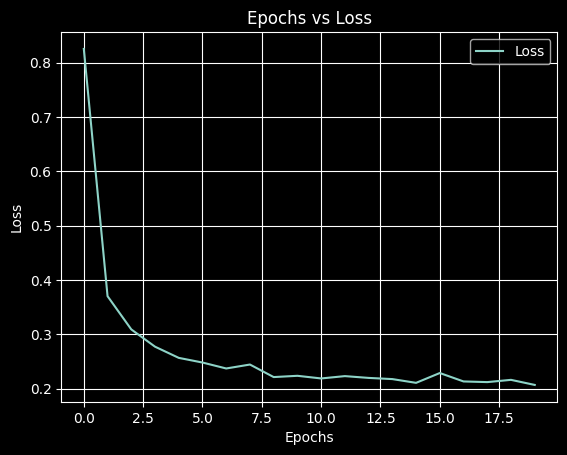

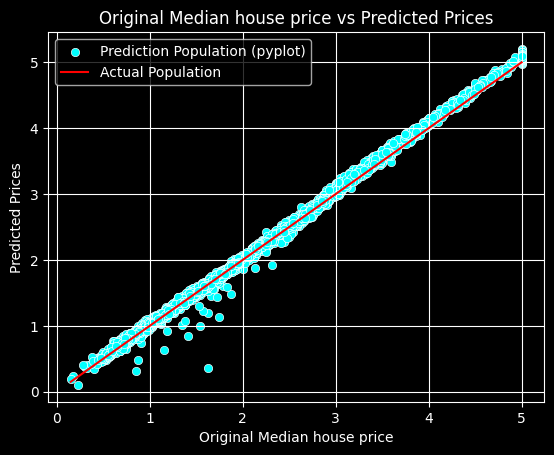

<Axes: xlabel='MedHouseVal', ylabel='Count'>

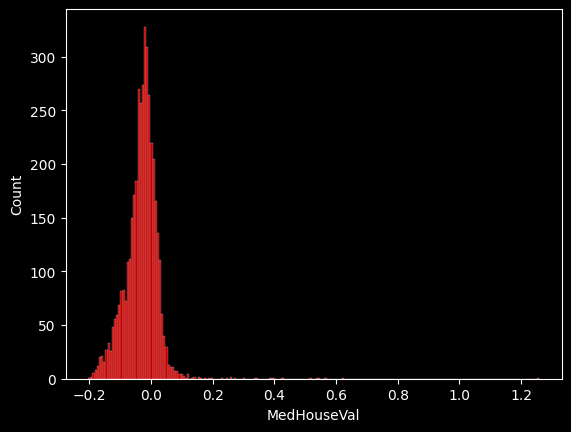

In [6]:

# Final Linear Project to move on to Classifications. Self paced learning.
# Title: Predicting Median House Value in California Using Linear Regression
# Author: Ayodeji Osungbohun
# Disclaimer: Every single line of code was written by the author



import numpy as np # import for arrays and high scale computations
import pandas as pd # import for initializing data and working them out effeciently
import tensorflow as tf # import tf for keras models
from tensorflow.keras.callbacks import EarlyStopping # Stop helps combat overfitting
import matplotlib.pyplot as plt # plot data
import seaborn as sns # advanced plotting
from sklearn.datasets import fetch_california_housing # dataset import
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error #  metrics for checking progress and score of model
from sklearn.linear_model import Lasso, Ridge, RidgeCV #fine tunning models to compare to tensorflow models
from sklearn.model_selection import train_test_split, GridSearchCV # split data training and testing and finetuning grid options
from sklearn.compose import ColumnTransformer # column transformer to scale data
from sklearn.preprocessing import StandardScaler, OneHotEncoder # scaler for inputs or datasets and onehotencoder turn categorical values into binary numbers 0 and 1 like a classification like male and female sorting

# fetch data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Print data
print(df.head(10))
print(df.isna().sum())#check if there are any nan

#drop duplicates so it dosen't hinder training
df = df.drop_duplicates()
print(df)



x = df.drop('Population', axis=1) # Drop values
y = df['MedHouseVal'] # Select features
print(x, y)



# Encode categorical features with OneHotEncoder
categorical_features = x.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Scale numerical features with Standard scaler
numerical_features = x.select_dtypes(include=['number']).columns.tolist()
numerical_transformer = StandardScaler()

# Preprocessing the dataset
preprocessed = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

#Process transforming the x values in the dataset
x_proccessed_scale = preprocessed.fit_transform(x)

# Train the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

# Scale the x train and x test
x_train_processed = preprocessed.fit_transform(x_train)
x_test_processed = preprocessed.transform(x_test)

# Baseline Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(x_train_processed.shape[1],)),
    # Weights two and gradients activations using relu
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),# speeds up the process
    tf.keras.layers.Dropout(0.3),# Drops out when it starts to overfit

    # Weights two and gradients activations using relu
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),# speeds up the process
    tf.keras.layers.Dropout(0.2),# Drops out when it starts to overfit

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),# speeds up the process
    tf.keras.layers.Dropout(rate=0.1),# Drops out when it starts to overfit

    tf.keras.layers.Dense(1)
])


ridge_model = Ridge(alpha=0.1)
ridge_model.fit(x_train_processed, y_train)

y_pred_ridge = ridge_model.predict(x_test_processed)

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(x_train_processed, y_train)

y_pred_lasso = lasso_model.predict(x_test_processed)


# fine tuning with a regularization model GridsearchCV
ridge = Ridge()

params = {'alpha': [0.2, 0.25, 0.5, 0.3]}
grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error')
grid.fit(x_train_processed, y_train)
y_pred_grid = model.predict(x_test_processed)

# Early stopping for helping prevent overtraining and it stops early if the patience number is matched
early_stopper = EarlyStopping(patience=15, restore_best_weights=True)

model.compile(optimizer='Adam', loss='mean_absolute_error')# Optimizer and loss initialization

# Trained the model and named it history to call in later
history = model.fit(x_train_processed, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopper])

y_pred = model.predict(x_test_processed).flatten() # Prediction model through the x_test which are our values from the training of the x values

# Metrics for the baseline model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Displaying the results for the  tuning model
print(f"Grid search Best alpha: {grid.best_params_}")
print(f"Grid search Scorer: {grid.scorer_}")
print(f'Grid search Best score: {grid.best_score_:.2f}')

#Displaying the results for the Ridge tuning model
print(f"Ridge best alpha: {ridge_model.alpha}")

print(f"Lasso best alpha: {lasso_model.alpha}")

#  Displaying the results for the Baseline model
print(f"Mean squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root mean squared Error: {rmse:.2f}")
print(f"r2 score: {r2:.2f}")

for actual, pred in zip(y_test[: 10], y_pred[: 10]):
  print(f"Original Median house price: {actual:.2f}, Predicted prices: {pred:.2f} ")

feature_name = preprocessed.get_feature_names_out()

if len(feature_name) > 0:
  if hasattr(ridge_model, 'coef_'):
    ridge_coeffecients = pd.Series(data=ridge_model.coef_, index=feature_name)
  elif hasattr(lasso_model, 'coef_'):
    lasso_coeffecients = pd.Series(data=lasso_model.coef_, index=feature_name)
  else:
    print("Error displaying coeffecients")

print(f"Ridge Coeffecients: {ridge_coeffecients}")
print(f"Lasso Coeffecients: {ridge_coeffecients}")


plt.style.use('dark_background')

#plot history. Epochs vs loss
plt.plot(history.history['loss'], label='Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Plotting the model
sns.scatterplot(x=y_test.values.flatten(), y=y_pred, color='cyan', label='Prediction Population (pyplot)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Actual Population')
plt.xlabel('Original Median house price')
plt.ylabel('Predicted Prices')
plt.title('Original Median house price vs Predicted Prices')
plt.grid(True)
plt.legend()
plt.show()

residuals = y_test - y_pred
sns.histplot(data=residuals, color='red')

# Model evaluation: My models are still being trained I'll update the metrics after
# I get the best one but I do realize now why I was once told that said before that if a model is a 1 without cleaning
# the data or preprocessing or using other cross validation it's prolly overfitting
# bcuz I never used all these thing to get the best generalization
# I learned that coeffecients could be the most important thing in a good model.




